# General probabilistic 1D linear regression experiments

When data is generated from a GP, it is unsurprising that a GP performs well and this also applies to other models. However, when the true data generating distribution is more unusual, how does directly targeting the predictive distribution compare to Bayesian approaches?

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.optim as optim
# import gpytorch
# from torch.utils.data import DataLoader, TensorDataset

In [2]:
# MPS (apple silicon support)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
colors = ["royalblue", "red", "orange"]

## Gaussian with heteroscedastic variance

In [81]:
sigma = np.vectorize(lambda x : 0.05*(np.exp((1-2*x**2)*np.sin(7*x)))**1.2)
mu = np.vectorize(lambda x : -0.5 * x * np.sin(10*x))

n = 1000
x = np.random.uniform(0, 1, n)
x = x[(x < 0.4) | (x > 0.5)]  # missing data between 0.4 and 0.5
x = x[(x < 0.85)]  # missing data above 0.85
y = np.random.normal(mu(x), sigma(x))

In [82]:
x_vals = np.linspace(0, 1, 200)
mu_vals = mu(x_vals)
sigma_vals = sigma(x_vals)

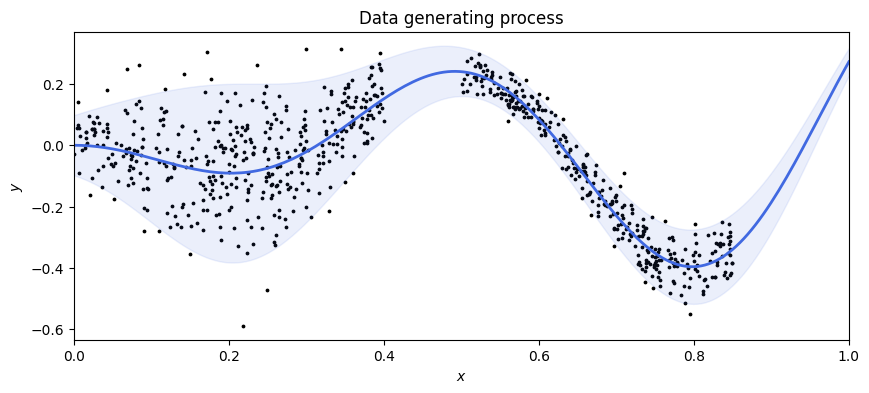

In [83]:
norm_crit = norm.ppf(0.975)

plt.figure(figsize=(10,4))
plt.scatter(x, y, s=3, color="black")
plt.fill_between(x_vals, mu_vals-norm_crit*sigma_vals, mu_vals+norm_crit*sigma_vals, color=colors[0], alpha=0.1)
plt.plot(x_vals, mu_vals, color=colors[0], linewidth=2)
plt.xlim(0,1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.title("Data generating process")
plt.show()

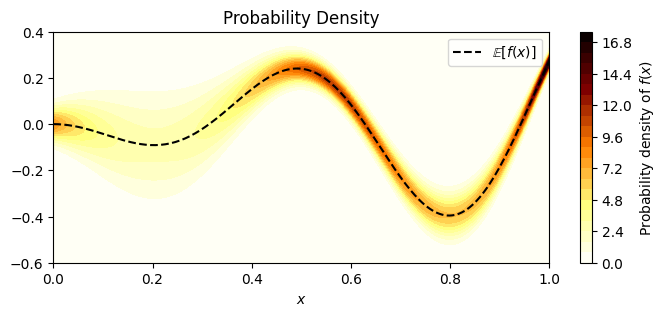

In [84]:
m = 1000
x_mesh, y_mesh = np.meshgrid(np.linspace(0, 1, m), np.linspace(-0.6, 0.4, m))
Z = norm(mu(x_mesh), sigma(x_mesh)).pdf(y_mesh)

plt.figure(figsize=(8,3))
plt.plot(x_vals, mu_vals, color="black", linestyle="--", label="$\mathbb{E}[f(x)]$")
contour = plt.contourf(x_mesh, y_mesh, Z, levels=25, cmap="afmhot_r") 
plt.colorbar(contour, label="Probability density of $f(x)$")
plt.xlim(0,1)
plt.title("Probability Density")
plt.legend()
plt.xlabel("$x$")
plt.show()

### GP model

### Neural Moment Approximator

In [85]:
def t_log_pdf(y, loc, scale, df):
    return (
        torch.lgamma((df+1)/2) - torch.lgamma(df/2) - 0.5*torch.log(df * torch.pi) - torch.log(scale)
        - ((df+1)/2) * torch.log(1 + ((y - loc)**2) / (df * scale**2))
    ).to(dtype=torch.float32)

def norm_log_pdf(y, loc, scale):
    return (
        - 0.5*torch.log(torch.ones(y.shape[0], device=device)*2*torch.pi) -torch.log(scale)
        - (y - loc)**2 / (2 * scale**2)
    )#.to(dtype=torch.float32)

# def skew_t_log_pdf(y, loc, scale, ...):


In [86]:
class NormDistributionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Softplus(beta=1.0, threshold=20.0),
            nn.Linear(64, 128),
            nn.Softplus(beta=1.0, threshold=20.0),
            nn.Linear(128, 64),
            nn.Softplus(beta=1.0, threshold=20.0),
        )
        
        self.loc_head = nn.Linear(64, 1)
        self.scale_head = nn.Linear(64, 1)

    def forward(self, x):
        hidden = self.net(x)
        loc = self.loc_head(hidden)
        scale = torch.nn.functional.softplus(self.scale_head(hidden)) + 1e-6
        
        return (loc, scale)

In [87]:
x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device=device)
y_train = torch.tensor(y, dtype=torch.float32).to(device=device)

model = NormDistributionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [88]:
n_epochs=10_000
for epoch in range(n_epochs):
    optimizer.zero_grad()

    # forward pass
    loc, scale = model(x_train)
    log_pdf = norm_log_pdf(y_train, loc.squeeze(), scale.squeeze())
    loss = -torch.mean(log_pdf)

    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.9542
Epoch 1000, Loss: -1.1010
Epoch 2000, Loss: -1.1795
Epoch 3000, Loss: -1.1804
Epoch 4000, Loss: -1.1816
Epoch 5000, Loss: -1.1818
Epoch 6000, Loss: -1.1819
Epoch 7000, Loss: -1.1781
Epoch 8000, Loss: -1.1765
Epoch 9000, Loss: -1.1741


In [89]:
x_vals_tensor = torch.tensor(x_vals, dtype=torch.float32).unsqueeze(1).to(device)

model.eval()
with torch.no_grad():
    loc_vals, scale_vals = model(x_vals_tensor)

    loc_vals = loc_vals.cpu().squeeze()
    scale_vals = scale_vals.cpu().squeeze()

In [90]:
print(torch.min(loc_vals) - torch.max(loc_vals))

tensor(-0.6408)


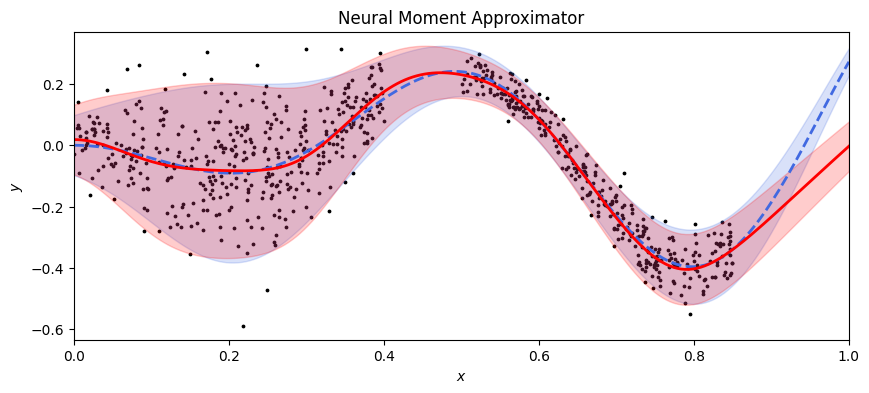

In [91]:
plt.figure(figsize=(10,4))
plt.scatter(x, y, s=3, color="black")
plt.fill_between(x_vals, mu_vals-norm_crit*sigma_vals, mu_vals+norm_crit*sigma_vals, color=colors[0], alpha=0.2)
plt.fill_between(x_vals, loc_vals-norm_crit*scale_vals, loc_vals+norm_crit*scale_vals, color=colors[1], alpha=0.2)
plt.plot(x_vals, mu_vals, color=colors[0], linewidth=2, linestyle="--")
plt.plot(x_vals, loc_vals, color=colors[1], linewidth=2)
plt.xlim(0,1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.title("Neural Moment Approximator")
plt.show()


Training directly on the log probability density (with the right distribution - Gaussian in this case) leads to a very close fit to the true data generating distribution where data is observed (capturing aleotoric uncertainty well) but there is no regularisation to prevent wildly incorrect guesses on out of distribution araes (failing to capture epsitemic uncertainty).